#Data

##Exploration

  In this chapter, we are going to study the data that we are going to use to train and validate our models. We are going to preprocess the data too.

First, we need to import our data from the drive:

In [ ]:
import time

notebook_startime = time.time()
ARCHITECTURE_NUMBER=3

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install --quiet hyperas

In [ ]:
from google.colab import drive    #We first import the dataset from the drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import random
import keras
import os

seed=0

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(seed)

We need to import the dataset as a pandas dataframe

In [ ]:
import pandas as pd
import numpy as np

df=pd.read_csv('/content/drive/MyDrive/Glucose_measurements_sample(1).csv')     #Import of the dataset as a pandas dataframe

Next, we need to join the Year/Month/Day column withe the Hour:Minute:Second column to create a single column with all the information of the dates tha we need

In [ ]:
df['Measurement_date']=df['Measurement_date']+' '+df['Measurement_time']   #Joining of those two date columns in a single one
df=df.drop(columns=['Measurement_time'])         #Drop the Hour:Minute:Second column now that this information is contained in the 'Measurement_Date' column

In [ ]:
df.head()      #Display of the whole dataframe

,Patient_ID,Measurement_date,Measurement
0,LIB193263,2020-06-09 19:08:00,99
1,LIB193263,2020-06-09 19:23:00,92
2,LIB193263,2020-06-09 19:38:00,86
3,LIB193263,2020-06-09 19:53:00,85
4,LIB193263,2020-06-09 20:08:00,85


In [ ]:
df.describe()    #get some general statistics from the dataframe in question

,Measurement
count,3.000000e+06
mean,1.589509e+02
std,6.543033e+01
min,4.000000e+01
25%,1.100000e+02
50%,1.480000e+02
75%,1.970000e+02
max,5.000000e+02


Each element of date column that we have just created next to be converted from string to TimeStamp

In [ ]:
df['Measurement_date']=pd.to_datetime(df['Measurement_date'],format='%Y-%m-%d %H:%M:%S.%f')   #Conversion from string to timestamp

In [ ]:
print(type(df['Measurement_date'][0]))                #Check if we have the 'Measurement_date' column in a timestamp format

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


Next, the date column that we just have converted to timestamp is going to be set as the index of our dataframe

In [ ]:
df.set_index('Measurement_date', inplace = True)      #Making the whole date column the index of the dataframe

Making a simple visualization of the csv of the data

In [ ]:
df.head()       #Visualization of the head of the dataframe

,Patient_ID,Measurement
Measurement_date,,
2020-06-09 19:08:00,LIB193263,99
2020-06-09 19:23:00,LIB193263,92
2020-06-09 19:38:00,LIB193263,86
2020-06-09 19:53:00,LIB193263,85
2020-06-09 20:08:00,LIB193263,85


Now, we can start playing with the dataframe to extract information. First, we are going to extract the number of different patients whose glucose time series are present in this dataframe by getting all the unique elements from the column 'Patient_ID', column that represents the patient to which the glucose measurement belongs to.

In [ ]:
patients=df['Patient_ID'].unique()     #Getting the unique patients and putting them into a list of unique patients
print(len(patients))                   #Visualization of the number of unique patients of this dataset

110


In [ ]:
print(patients[0])                     #Print the first patient ID in the list

LIB193263


In [ ]:
print(df.isnull().sum())               #Check the number of Nans that there are in the whole dataframe of patients. As we can see, we don't have to worry in Nan values.

Patient_ID     0
Measurement    0
dtype: int64


Now, we are going to take the glucose time series data related to the first patient of this list of unique patients. Next we are going to plot this timeseries with different frequencies, just so we can visualize the data which we are working with.

In [ ]:
patient1 = df[df['Patient_ID'] == 'LIB193263']      #the glucose time series dataframe related to the first patient of the list of unique patients

We first make a visualization of the data in a little timespam, like a few hours

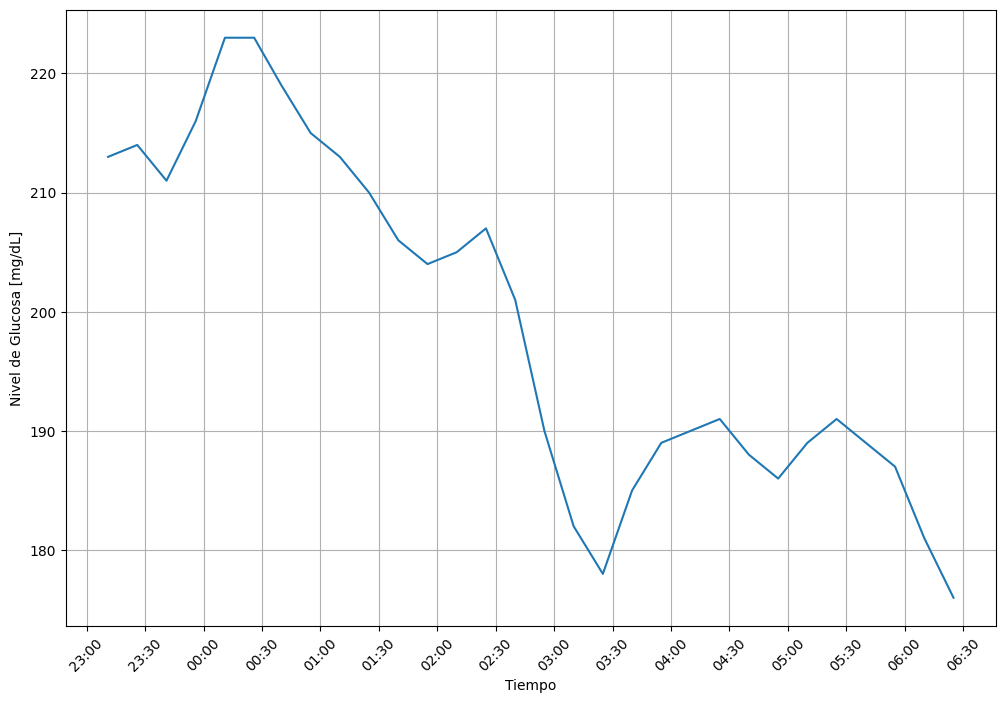

In [ ]:
import matplotlib.pyplot as plt        #Simple matplotlib visualization of a patient levels of glucose time series in a relatively small time range
import matplotlib.dates as md

fig, ax = plt.subplots(figsize = (12, 8))
original_data=patient1['Measurement'][400:430]
ax.plot(patient1['Measurement'][400:430])
plt.xlabel('Tiempo')
plt.ylabel('Nivel de Glucosa [mg/dL]')

ax.xaxis.set_major_locator(md.MinuteLocator(byminute = [0, 30]))
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45)

plt.grid()
plt.show()

And them we are going to make a visualization of the data in a larger timespam, like a few days

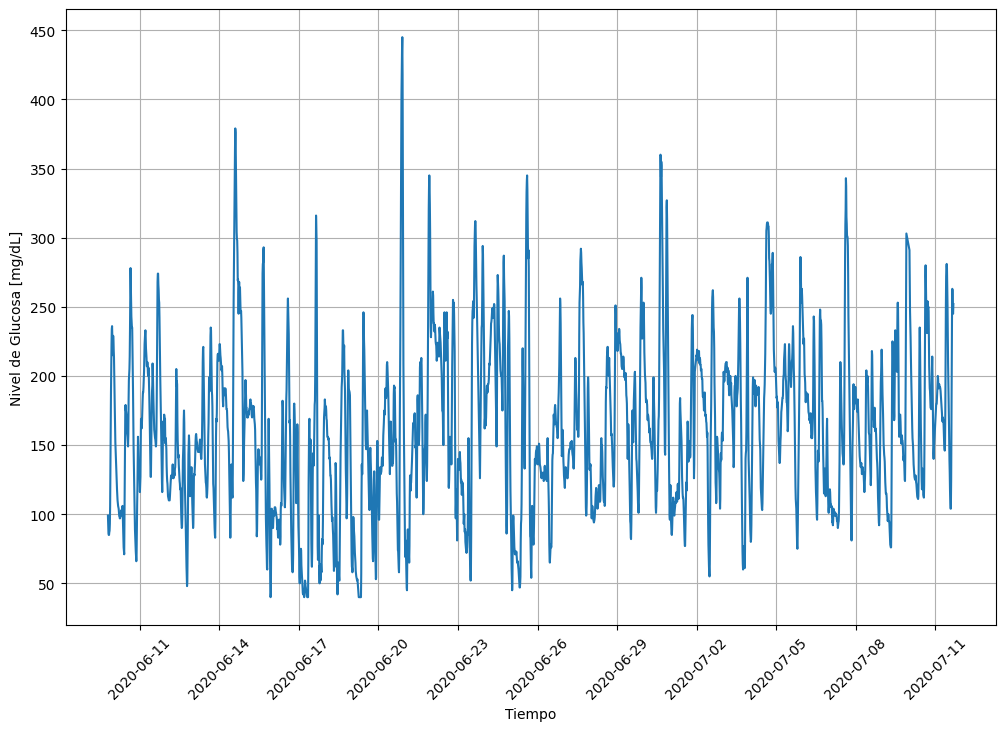

In [ ]:
import matplotlib.pyplot as plt       #Simple matplotlib visualization of a patient levels of glucose time series in a wider time range
import matplotlib.dates as md

fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(patient1['Measurement'][:3000])
plt.xlabel('Tiempo')
plt.ylabel('Nivel de Glucosa [mg/dL]')

ax.xaxis.set_major_locator(md.DayLocator(interval=3))
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45)

plt.grid()
plt.show()

And them, we need to append in a list the different timeseries related to every patient each one as a element of a list that will contain the dataframes of all patients differentiated

In [ ]:
time_series_per_patient=[]     #List in which we are going to store the part of the dataframe related to each patient each one as a different element of this list

for patient in patients:
  time_series_per_patient.append(df[df['Patient_ID'] == patient])     #Appending the information related to each patient each one as a different element of this list

In [ ]:
time_series_per_patient[0].head()              #check the time series correspondent to the first patient in the list

,Patient_ID,Measurement
Measurement_date,,
2020-06-09 19:08:00,LIB193263,99
2020-06-09 19:23:00,LIB193263,92
2020-06-09 19:38:00,LIB193263,86
2020-06-09 19:53:00,LIB193263,85
2020-06-09 20:08:00,LIB193263,85


##Resampling

Now, we are going to measure the elements of every time series that are oversampled or undersampled, under and over 15 min, timestamp that have to be the sampling frequency of every time series. For those elements that are undersampled, we are going to take the missing values until the next value of glucose, because maybe if we miss one or two ticks of glucose measurement in a gap, we can interpolate this gap. For more ticks of missing values, we could treat this gap of missing values as a real gap that will not be interpolated, because if we interpolate two days of missing values of glucose, the dataset will change a lot in terms of reality, which is something that we dont want at all.

In [ ]:
oversamples=[]              #list which contains a counter of oversample values for every patient
undersamples=[]             #list which contains a counter of undersample values for every patient
undersample_freq=[]         #list which contains the number of missing values in an undersampled gap

for time_series in time_series_per_patient:
  time_diff = time_series.index.to_series().diff()[1:]                              #list of sampling frequencies
  morethan15min_positions = time_diff[time_diff > pd.Timedelta(minutes=15)].index   #+1 index of those positions with a sampling frequency with more than 15 minutes of value
  lessthan15min_positions = time_diff[time_diff < pd.Timedelta(minutes=15)].index   #+1 index of those positions with a sampling frequency with less than 15 minutes of value
  oversamples.append(len(lessthan15min_positions))                                  #list of number of samples  with less than 15 minutes of sampling frequency from every every patient
  undersamples.append(len(morethan15min_positions))                                 #list of number of samples  with more than 15 minutes of sampling frequency from every every patient
  undersample_freq+=list(time_diff[time_diff > pd.Timedelta(minutes=15)])           #list of sampling frequency values that are over 15 minutes from every patient

In [ ]:
print(np.sum(oversamples))        #Number of oversample values in the whole dataframe
print(np.sum(undersamples))       #Number of undersample values in the whole dataframe

136533
167091


In [ ]:
print(np.sum(pd.Series(undersample_freq) > pd.Timedelta(minutes=45)))     #If the gap of missing values is equal or less than 30 minutes, we are going to interpolate that gap

16345


Then, we check the date of beginning and end of some time series correspondent to the first 5 patients in the list, the length of every time series and the length that every time series from every patient must have to obey an uniform sampling frequency. The uniform length is the length that the time series must have to achieve sampling every 15 minutes form start date to end date of the time series.

Of course, with the resampling of these time series, we will do various things:

1- First, we are going to determine where the gaps with more that 45 minutes are, i.e. those gaps where more two values of glucose are missing, those gaps are going to be untouched. But next to finding where this gaps are, we are going to locate those gaps that are less or equal to 45 minutes, i.e. those gaps where there are two or one values missing and we are going to interpolate this gaps.

2- Next, we are going to correct uneven sampling frequencies. You see, the mayority of the samples of the time series are separated by 15 minutes, but some values are separated 16 minutes or 14 minutes or even less or more. We are going to make this values be separated by 15 minutes only with interpolating tools.

by doing these steps in the resample phase of this work, we are most likely not to achieve this Uniform Length mencioned earlier, because, we are going to leave these more than 45 minutes gaps untouched, so at the end, the actual length of the time series of every patient will be most likely different to its uniform length.

In [ ]:
for time_series in time_series_per_patient[:5]:
  print('Patient_ID:',time_series['Patient_ID'][0])
  print('Beggining datetime:',time_series.index[0])
  print('Ending datetime:',time_series.index[-1])
  print('Actual Length:',len(time_series))
  print('Uniform Length:',int((time_series.index[-1]-time_series.index[0])/pd.Timedelta(minutes=15)))
  print('TimeDelta:',(time_series.index[-1]-time_series.index[0]))
  print('--------------------------------\n')

Patient_ID: LIB193263
Beggining datetime: 2020-06-09 19:08:00
Ending datetime: 2022-03-19 07:32:00
Actual Length: 60098
Uniform Length: 62161
TimeDelta: 647 days 12:24:00
--------------------------------

Patient_ID: LIB193264
Beggining datetime: 2020-06-10 00:54:00
Ending datetime: 2022-03-19 11:56:00
Actual Length: 26787
Uniform Length: 62156
TimeDelta: 647 days 11:02:00
--------------------------------

Patient_ID: LIB193265
Beggining datetime: 2019-01-27 10:52:00
Ending datetime: 2022-03-19 22:04:00
Actual Length: 46576
Uniform Length: 110156
TimeDelta: 1147 days 11:12:00
--------------------------------

Patient_ID: LIB193266
Beggining datetime: 2020-10-08 18:03:00
Ending datetime: 2022-03-21 12:09:00
Actual Length: 55308
Uniform Length: 50760
TimeDelta: 528 days 18:06:00
--------------------------------

Patient_ID: LIB193267
Beggining datetime: 2020-06-09 19:07:00
Ending datetime: 2022-03-17 20:15:00
Actual Length: 55501
Uniform Length: 62020
TimeDelta: 646 days 01:08:00
-------

Next cell is to delete rare cases of duplicate values from every patient, i.e. timestamps where there are more than one glucose measurements in one patient. We are going to drop the column 'patient_ID' that we don't need because we have stored the patient's ID index and location in the 'patients' list.

In [ ]:
#print(time_series_per_patient[0].loc['2020-06-10 09:20:00':])

for i in range(0,len(time_series_per_patient)):
  time_series_per_patient[i]= time_series_per_patient[i][~time_series_per_patient[i].index.duplicated(keep='first')]         #We are going to delete rare cases of duplicates from every patient's time series and we are going to keep the first value of the duplicate. For duplicate, we mean, various glucose measurements for one timestamp
  time_series_per_patient[i]=time_series_per_patient[i].drop(columns=['Patient_ID'])                                         #Drop the Patient_ID column, because the location of the patients_IDs are located in the 'patients' list

Next, we are going to reindex and resample between every gap of more than 45 minutes (leaving those gaps untouched) to have a uniform sampling frequency for every patient between those gaps.

In [ ]:
for index,time_series in enumerate(time_series_per_patient):                                       #Loop from every patient's glucose time series
  time_diffs = time_series.index.to_series().diff()                                                #List of sampling frequencies from the current time series' iteration
  time_diffs=time_diffs.shift(periods=-1)                                                          #Shift this list so that value and sampling frequency correspond to each other
  morethan15min_positions = time_diffs[time_diffs > pd.Timedelta(minutes=45)].index                #Index of those positions where the gaps of missing data is more than 45 minutes

  last_datetime=time_series.index[0]                                                               #These two values are the last datetime index and the 'total_slice' parameter is where we are going to store current slices in the next loop
  total_slice=None

  for datetime in morethan15min_positions:                                                         #Loop through every gap of more that 45 minutes
    current_slice=time_series[last_datetime:datetime]                                              #This is the dataframe slice between gaps of more than 45 values of the current iteration
    #https://stackoverflow.com/questions/47148446/pandas-resample-interpolate-is-producing-nans
    oidx = current_slice.index                                                                     #Parameter where we are going to store the current slice index (old index)
    nidx = pd.date_range(oidx.min(), oidx[-1], freq='15T')                                         #Parameter where we are going to store the current slice index is there were a uniform sampling frequency of 15 minutes (new index)
    current_slice = current_slice.reindex(oidx.union(nidx)).interpolate('index').reindex(nidx)     #Current slice with the new index values interpolated from the values of the old index
    total_slice=pd.concat([total_slice, current_slice], axis=0)                                    #Store this resampled slice in the 'total_slice' parameter
    last_datetime=datetime+pd.Timedelta(seconds=1)                                                 #Update the 'last_datetime' parameter so the next current slice (in the next iteration) is located correctly

  time_series_per_patient[index]=total_slice                                                       #We are going to store the resampled and reindexed time series from every patient in the 'time_series_per_patient' list

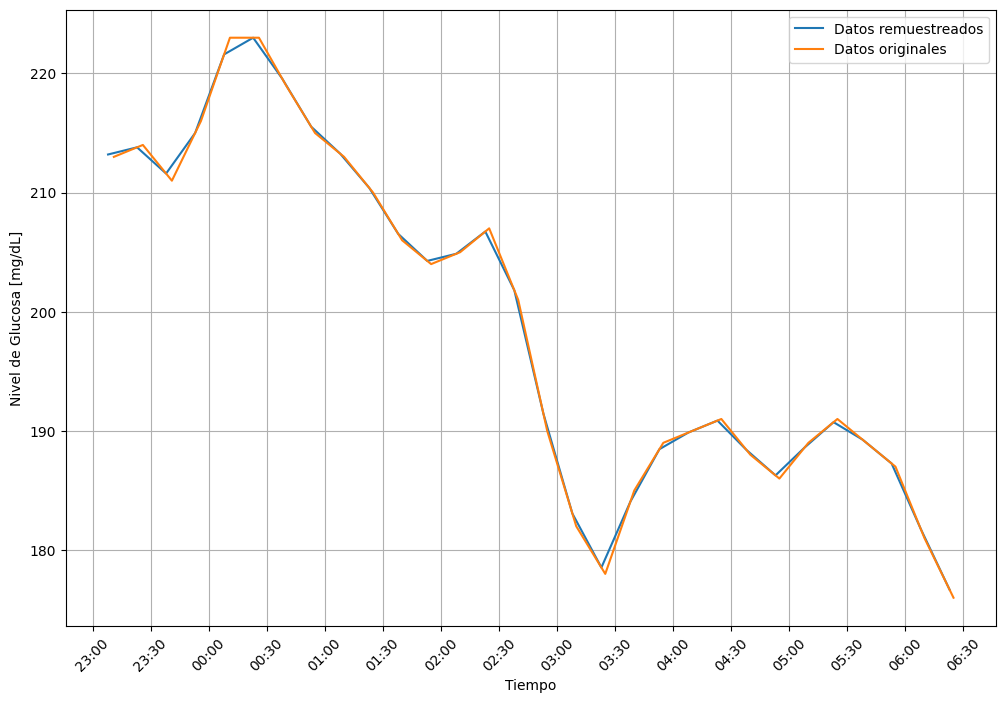

In [ ]:
import matplotlib.pyplot as plt        #Simple matplotlib visualization of the graph that we plotted earlier to check whether if the data keeps the coherence after getting resampled. We can see that the two graphs matches
import matplotlib.dates as md

fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(time_series_per_patient[0]['Measurement'][400:430],label='Datos remuestreados')
ax.plot(original_data,label='Datos originales')
plt.xlabel('Tiempo')
plt.ylabel('Nivel de Glucosa [mg/dL]')

ax.xaxis.set_major_locator(md.MinuteLocator(byminute = [0, 30]))
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45)

plt.legend()
plt.grid()
plt.show()

We check wether if we have created nans in the process of resampling, we can see in the next code cell that we haven created such nan values.

In [ ]:
sumatory=0

for time_series in time_series_per_patient:
  sumatory+=int(time_series.isnull().sum())

print(sumatory)

0


In the next code cell, we are going to check if we have values that are sampled over and less than 15 minutes.

In [ ]:
oversamples=[]              #list which contains a counter of oversample values for every patient
undersamples=[]             #list which contains a counter of undersample values for every patient
undersample_freq=[]         #list which contains the number of missing values in an undersampled gap

for time_series in time_series_per_patient:
  time_diff = time_series.index.to_series().diff()[1:]
  morethan15min_positions = time_diff[time_diff > pd.Timedelta(minutes=15)].index
  lessthan15min_positions = time_diff[time_diff < pd.Timedelta(minutes=15)].index
  oversamples.append(len(lessthan15min_positions))
  undersamples.append(len(morethan15min_positions))
  undersample_freq+=list(time_diff[time_diff > pd.Timedelta(minutes=15)])

print(np.sum(oversamples))        #Number of oversample values in the whole dataframe
print(np.sum(undersamples))       #Number of undersample values in the whole dataframe
print(np.sum(pd.Series(undersample_freq) > pd.Timedelta(minutes=45)))     #If the gap of missing values is equal or less than 30 minutes, we are going to interpolate that gap

0
16235
16235


We can observe that there are not values with less sampling frequency than 15 minutes, with only have samples over that value, other than the elements that are separated by a uniform 15 minutes, we only have elements which sampling frequency is over 15 minutes, and those gaps correspond to over 45 minutes gaps, i.e. more than two missing vale gaps. That is correct, because, as we said earlier we will only have one uniform sampling frequency other than the gaps over 45 minutes that will be untouched.

In [ ]:
for index,time_series in enumerate(time_series_per_patient[:5]):
  print('Patient_ID:',patients[index])
  print('Beggining datetime:',time_series.index[0])
  print('Ending datetime:',time_series.index[-1])
  print('Actual Length:',len(time_series))
  print('Uniform Length:',int((time_series.index[-1]-time_series.index[0])/pd.Timedelta(minutes=15)))
  print('TimeDelta:',(time_series.index[-1]-time_series.index[0]))
  print('--------------------------------\n')

Patient_ID: LIB193263
Beggining datetime: 2020-06-09 19:08:00
Ending datetime: 2022-03-18 23:00:00
Actual Length: 60157
Uniform Length: 62127
TimeDelta: 647 days 03:52:00
--------------------------------

Patient_ID: LIB193264
Beggining datetime: 2020-06-10 00:54:00
Ending datetime: 2022-03-18 20:16:00
Actual Length: 26797
Uniform Length: 62093
TimeDelta: 646 days 19:22:00
--------------------------------

Patient_ID: LIB193265
Beggining datetime: 2019-01-27 10:52:00
Ending datetime: 2022-03-16 21:29:00
Actual Length: 46381
Uniform Length: 109866
TimeDelta: 1144 days 10:37:00
--------------------------------

Patient_ID: LIB193266
Beggining datetime: 2020-10-08 18:03:00
Ending datetime: 2022-03-17 18:22:00
Actual Length: 44514
Uniform Length: 50401
TimeDelta: 525 days 00:19:00
--------------------------------

Patient_ID: LIB193267
Beggining datetime: 2020-06-09 19:07:00
Ending datetime: 2022-03-17 07:43:00
Actual Length: 54693
Uniform Length: 61970
TimeDelta: 645 days 12:36:00
-------

We can observe that the actual length is not equal to the desired length (the length that the time series would have if we had measurements every 15 minutes non stop from start date to end date from the time series) because we have left the gaps over 45 minutes untouched.

##Preprocessing

The plan for the work is that the neural network uses a fit_generator function, so that we can utilize the GPU in the training of our neural network without running out of GPU memory in the way.

To do that, we are going to take the time series of every patient, we are going to window every time series, and we are going to store within the folder 'src_folder' the windowed time series of every patient in a npy file (every patient will have a npy file named after its own patient_ID), this windowed time series must be of shape (len(time_series)-WINDOW_LENGTH+1,WINDOW_LENGTH, NUM_FEATURES), because we are working with an unidimensional time series, NUM_FEATURES must be equal to one.

In [ ]:
import os

src_folder = "/content/windowed_dataset/"                                                   #The name of the folder where we are going to store the windowed time series of each patient

def create_folder(folder_name):                                                             #Function to create a directory only if that directory doesn't exist
  if not os.path.exists(folder_name):
      os.makedirs(folder_name)

create_folder(src_folder)                                                                   #Creation of the folder mentioned earlier
AHEAD_STEPS_PREDICTION=4                                                                    #Number of steps to predict ahead. In the case that we want to predict 1 hour ahead, AHEAD_STEPS_PREDICTION must be 4, because every value corresponds to the sampling frequency separation (15 minutes), 4 values ahead correspond to one hour ahead
WINDOW_STEPS=6                                                                              #Number of steps before the actual step we are going to take to input a window for the model to predict
PREDICTION_WINDOW=AHEAD_STEPS_PREDICTION+WINDOW_STEPS                                       #Add of these two parameters mentioned earlier                                                                         #Maybe we could take a normalization parameter to normalize those values that we are going to input our model
window_count=0

for patient_index,time_series in enumerate(time_series_per_patient):                        #Loop though every patient's glucose time series
  time_diffs = time_series.index.to_series().diff()                                         #Parameter where we are going to store the sampling frequency between every element of the current time series
  time_diffs=time_diffs.shift(periods=-1)                                                   #Shift of this parameter to make it correspong to every element of the current time series
  morethan15min_positions = time_diffs[time_diffs > pd.Timedelta(minutes=45)].index         #Those index position where there is a gap of data (over 45 minutes)
  last_datetime=time_series.index[0]                                                        #We set the last datetime of the slice to be the first index of the slice in the next loop's iterations

  for iter,datetime in enumerate(morethan15min_positions):                                  #Loop trough every gap of missing data (over 45 minutes)
    current_slice=time_series[last_datetime:datetime]                                       #Slice of time series between gaps of missing data (over 45 minutes)
    if len(current_slice)>=PREDICTION_WINDOW:                                               #If the current_slice of time series is bigger that the PREDICTION_WINDOW parameter, we can window this slice, so we keep ourselves in the loop
      windows=np.zeros((len(current_slice)-PREDICTION_WINDOW+1,PREDICTION_WINDOW,1))        #Array of zeros where we are going to store the current_slice of time series after being windowed
      for ind in range(0,len(current_slice)-PREDICTION_WINDOW+1):                           #Loop through the range of number of windows that we can create as from the current slice of time series
        windows[ind,:,:]=current_slice[ind:ind + PREDICTION_WINDOW]                         #We store the current window in the array of zeros mentioned earlier
      if iter==0:                                                                           #The general_windows parameter if where we are going to store all windows from all slices of data of the current patient. At the first slice, we initialize it as the windowed time_series of the current_slice of the current_slice
        general_windows=windows
      else:                                                                                 #But in the next slices we store the windowed current_slice with the last iteration general window with the numpy command 'concat' which allow us to update the 'general_windows' parameter without losing information at every iteration
        general_windows=np.concatenate((general_windows,windows),axis=0)
    last_datetime=datetime+pd.Timedelta(seconds=1)                                          #We update the next first datetime to index the next current_slice iteration

  np.save(src_folder+patients[patient_index],general_windows,allow_pickle=True)             #Next, we store the windowed time series of all of the current slices between gaps of missing data of each patient as a npy file named after the Patient's ID
  window_count+=np.shape(general_windows)[0]

print(np.shape(general_windows))                                                            #In order to check if everything is in order, we check the shape of the last windowed time series of the last patient of the iteration to check if the shape matches (n,PREDICTION_WINDOW,1), being n a parameter that changes in terms of the time series' length
print(window_count)                                                                         #Check number of windows

(5915, 10, 1)
2832381


##Train/Test Data Split

The development of this Master's Thesis involves choosing a sample group of patients (between 5 and 10 patients), we are going to call this group of patients 'control group'.We need to train our 'from the scratch' model individually in the control group. Next we are going to take a pretrained model, pretrained with the rest odf the patients, when it is pretrained, we are going to train this pretrained model in the every patient of the control group individually.

Finally, we are going to compare the performance of this 'from the scratch' model to the pretrained one, using different metrics.
Ideally, the time series of the patients from  the control group must be long time series, to have a good portion of time range of the time series to test the performance of our models, for that, for the control group, we should take patients with time series with good length.

In [ ]:
from sklearn.model_selection import train_test_split

CONTROL_GROUP_SIZE=5                                                                                               #Number of patients that will be in the control group

lengths=[]
for patient in patients:                                                                                           #A loop trough every filenames patient
  array=np.load(os.path.join(src_folder,patient)+'.npy',allow_pickle=True)                                         #Load its correspondent windowed dataset
  lengths.append(len(array))                                                                                       #Store its length in the self.lengths list

# Use sorted() to get a sorted version of the list along with their indices
sorted_numbers = sorted(enumerate(lengths), key=lambda x: x[1], reverse=True)

# Get the indices of the 5 highest values
highest_length_indices = [index for index, _ in sorted_numbers[:5]]

test_patients=[patients[index] for index in highest_length_indices]                                               #The test patients are those who have the five time series with more legth within all the patients
other_patients=[patients[index] for index in range(0,len(patients)) if index not in highest_length_indices]       #The train patients are the rest of the patients
train_patients,validation_patients=train_test_split(other_patients,test_size=0.2,random_state=0)
print(len(test_patients)+len(validation_patients)+len(train_patients))                                                                     #Check if the number of total patients is correct (It's correct, 110 patients, same as before)

110


In [ ]:
timestamps_test=[]
partial_timestamps=[]

for patient_index,patient in enumerate(test_patients):
  partial_timestamp=np.array(time_series_per_patient)[patients==patient]
  partial_timestamp=partial_timestamp[0].index
  partial_timestamps.append(partial_timestamp)
  timestamps_test+=list(partial_timestamp)

In [ ]:
from keras.utils import Sequence

class Custom_Generator(Sequence) :

  def __init__(self, filenames, batch_size) :
    self.filenames = filenames                                                                             #The list of patients that we are going to take in our fit_generator
    self.lengths=[]                                                                                        #A list where the legths of every windowed time series of each filenames patient will be stored
    self.indexes=[0]                                                                                       # The indexes where the windowed time series of every each filenames patients end

    for filename in self.filenames:                                                                        #A loop trough every filenames patient
        array=np.load(os.path.join(src_folder,filename)+'.npy',allow_pickle=True)                          #Load its correspondent windowed dataset
        self.lengths.append(len(array))                                                                    #Store its length in the self.lengths list
        self.indexes.append(np.sum(self.lengths))                                                          #And store its ending index in the self.indexes list

    self.n_frames=np.sum(self.lengths)                                                                     #self.n_frames will be the number of windows that we are going to have in this fit_generator
    self.batch_size = batch_size                                                                           #Specification of the batch size as an argument of the class
    self.current_filename=self.filenames[0]                                                                #Specification of the name of the first patient windowed time series that we are going to feed to the neural network
    self.last_iter_index=0                                                                                 #Parameter which is going to tell us if we have reached the end of a windowed file initializated to zero
    self.windowed_file=np.load(os.path.join(src_folder,self.filenames[0])+'.npy',allow_pickle=True)        #the first patient windowed file that we are going to feed to the neural network

  def __len__(self) :                                                                                      #Method which simply returns the number of steps per epoch that we need to run through an epoch of data in this fit_generator
    return (np.floor(self.n_frames / float(self.batch_size))).astype(np.int)                               #The number of steps per epoch is going to be defined as the floor of the total number of windows that we have in this fit generator divided by its batch size

  def __getitem__(self, idx) :                                                                             #Method with give us batch in terms of the input parameter idx, in the training of a model, the range of values of idx should go from zero to the number of steps per epoch
    first_batch_index=idx * self.batch_size                                                                #These two parameters combined with the self.indexes and self.lengths can give us the correspondent batches from every time series
    second_batch_index=(idx+1) * self.batch_size

    first_index=np.sum(np.array(self.indexes)<=first_batch_index)-1                                        #Indexes that specify us where the first and last window of the batch is in terms of self.filenames index positions
    last_index=np.sum(np.array(self.indexes)<=second_batch_index)-1

    beginning_filename=self.filenames[first_index]                                                         #first and windowed time series name files where the first and last windows of time series belongs to in this current batch of data
    ending_filename=self.filenames[last_index]

    series_first_index=np.abs(self.indexes[first_index]-first_batch_index)                                 #indexes wich will help us locate the windows that we want to add in the current batch of windows
    series_last_index=np.abs(self.indexes[last_index]-second_batch_index)

    batch_x=np.zeros((self.batch_size,WINDOW_STEPS,1))                                                     #arrays of zeros where we are going to store our x and y values to feed batches to the model in which the fit generator is hooked on
    batch_y=np.zeros((self.batch_size,1))

    if first_index==0 and self.last_iter_index!=0:                                                         #When we are at the first patient windowed dataset but the last iteration was not the first windowed dataset, i.e. when idx have reached the value of steps per epoch and is reseting again from zero
      self.windowed_file=np.load(os.path.join(src_folder,self.filenames[0])+'.npy',allow_pickle=True)      #We just set the first windowed dataset as the first patient windowed dataset without taking into account that the last windowed dataset was different

    if first_index!=0:                                                                                     #Explaining this later
      if self.last_iter_index!=first_index:
        self.windowed_file=np.load(os.path.join(src_folder,self.filenames[first_index])+'.npy',allow_pickle=True)

    if first_index==last_index:
      batch_x[:,:,:]=self.windowed_file[series_first_index:series_last_index,:WINDOW_STEPS,:]
      batch_y[:,:]=self.windowed_file[series_first_index:series_last_index,-1,:]
    elif np.abs(last_index-first_index)==1:
      len_first_slice=self.indexes[last_index]-first_batch_index
      batch_x[:len_first_slice,:,:]=self.windowed_file[series_first_index:,:WINDOW_STEPS,:]
      batch_y[:len_first_slice,:]=self.windowed_file[series_first_index:,-1,:]

      self.windowed_file=np.load(os.path.join(src_folder,self.filenames[last_index])+'.npy',allow_pickle=True)

      batch_x[len_first_slice:,:,:]=self.windowed_file[:series_last_index,:WINDOW_STEPS,:]
      batch_y[len_first_slice:,:]=self.windowed_file[:series_last_index,-1,:]
    else:
      len_first_slice=self.indexes[first_index+1]-first_batch_index
      batch_x[:len_first_slice,:,:]=self.windowed_file[series_first_index:,:WINDOW_STEPS,:]
      batch_y[:len_first_slice,:]=self.windowed_file[series_first_index:,-1,:]
      last_slice=len_first_slice

      for i in range(first_index+1,last_index):
        self.windowed_file=np.load(os.path.join(src_folder,self.filenames[i])+'.npy',allow_pickle=True)
        #print(i)
        intermediate_array=self.windowed_file[:,:,:]
        batch_x[last_slice:last_slice+len(intermediate_array),:,:]=intermediate_array[:,:WINDOW_STEPS,:]
        batch_y[last_slice:last_slice+len(intermediate_array),:]=intermediate_array[:,-1,:]
        last_slice+=len(intermediate_array)

      self.windowed_file=np.load(os.path.join(src_folder,self.filenames[last_index])+'.npy',allow_pickle=True)
      batch_x[last_slice:,:,:]=self.windowed_file[:series_last_index,:WINDOW_STEPS,:]
      batch_y[last_slice:,:]=self.windowed_file[:series_last_index,-1,:]

    #batch_x=batch_x
    #batch_y=denormalize(batch_y)
    batch=(batch_x,batch_y)
    self.last_iter_index=last_index
    return batch                                                                                                       #Returning the correspondent batch to the parameter idx

#Training

##Neural Network Arquitecture

Next, It's the phase related to designing the model, training it, and extracting the correspondent results of metrics. First, the presentation of the design of the model that we have proposed for the development of this Master's Thesis.

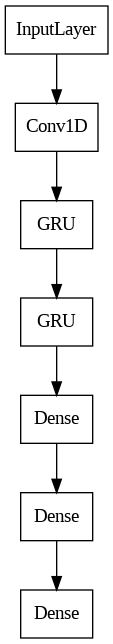

In [ ]:
import keras
import tensorflow as tf

TOTAL_EPOCHS=15

def create_model():                         #Function to create a recurrent neural network with a conv1d layers, a encoder LSTM, a decoder LSTM and fully connected layers at the end, this is known in the literature as an encoder-decoder recurrent neural network architecture.
  model=keras.models.Sequential()

  #model.add(keras.layers.Lambda(lambda x: x / 400))
  model.add(keras.layers.Conv1D(60,5,strides=1,padding='causal',activation='relu',input_shape=(None,1)))
  model.add(keras.layers.GRU(64,return_sequences=True))
  model.add(keras.layers.GRU(64,return_sequences=False))
  model.add(keras.layers.Dense(30))
  model.add(keras.layers.Dense(10))
  model.add(keras.layers.Dense(1))
  #model.add(keras.layers.Lambda(lambda x: x * 300))
  return model

model=create_model()                        #Then, we just call this function to create the correspondent model and plot it for visualization
keras.utils.vis_utils.plot_model(model, show_shapes=False, show_layer_names=False)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 60)          360       
                                                                 
 gru_4 (GRU)                 (None, None, 64)          24192     
                                                                 
 gru_5 (GRU)                 (None, 64)                24960     
                                                                 
 dense_6 (Dense)             (None, 30)                1950      
                                                                 
 dense_7 (Dense)             (None, 10)                310       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 51,783
Trainable params: 51,783
Non-trai

##Hyperparameter Optimization

Next, It's the time to optimize the parameters that are involved in the compile of the model, like learning rate, optimizer and loss. It's just like doing a random walk to find this parameters, but instead, we are going to use an especialized library for optimization of parameters (hyperas library). We first create the fit_generators that we are going to use for this hyperparameter optimization.

In [ ]:
train_generator=Custom_Generator(train_patients,128)    #Instantiation of Custon Generator mentioned earlier
validation_generator=Custom_Generator(validation_patients,128)
test_generator=Custom_Generator(test_patients,128)

Next, we perform hyperparameters oiptimization with the library that we mantioned earlier within the range that we set for every hyperparameter, for exple, for loss, we are only going to search in the space of 4 losses: msle, mse, mae and Huber.

In [ ]:
from hyperas.distributions import choice,loguniform,uniform
from hyperopt import Trials, STATUS_OK, tpe
from keras import backend as K
from keras.backend import clear_session
from tqdm.notebook import tqdm

optimization_startime=time.time()

losses=['mse','mae','huber_loss','msle','mean_absolute_percentage_error']                              #We first define the search space to optimize parameters
optimizers=['SGD','RMSprop','Adam','Adagrad']
space_tf = {'loss': choice('loss',losses),'optimizer': choice('optimizer',optimizers),'learning_rate':loguniform('learning_rate',np.log(1e-8),np.log(0.6))}
#space_tf = {'dense_depth':uniform('dense_depth',5,20),'n_hidden_neurons': uniform('n_hidden_neurons',1000,3000),'loss': choice('loss',losses),'optimizer': choice('optimizer',optimizers),'learning_rate':loguniform('learning_rate',np.log(1e-6),np.log(0.6))}

max_evals=15                                                     #Max of evaluations over the parameters that we want to optimize
epochs_per_eval=1                                                #number of epoch that our neural network will perform in each evaluation of the optimization of the parameters
pbar = tqdm(total=max_evals*epochs_per_eval, desc="Hyperopt")    #Custom loading bar to visualize the progress of the optimization algorithm

def create_optimized_model(space_sample):                        #Function to evaluate the performance of the algorithm with a set of hyperparameters to optimize. In this case, those parameters are the optimizer, the loos and the learning rate
    global pbar                                                  #This function just creates a model and lets it run truogh one epoch of out fit generator with with different hyperparameter combinations, those hyperparameters are in fact, the ones that we want to optimize
    clear_session()
    tf.random.set_seed(0)

    #dense_depth=int(space_sample['dense_depth'])
    #n_hidden_neurons=int(space_sample['n_hidden_neurons'])
    loss=space_sample['loss']
    optimizer=space_sample['optimizer']
    learning_rate=space_sample['learning_rate']

    model=create_model()     #n_hidden_neurons,dense_depth)
    model.compile(loss=loss,optimizer=optimizer,metrics=['mse'])
    K.set_value(model.optimizer.learning_rate, learning_rate)

    history=model.fit_generator(train_generator,epochs=epochs_per_eval,steps_per_epoch=int(train_generator.__len__()),verbose=0,shuffle=False)
    acc=np.amin(history.history['mse'])
    pbar.update()
    return acc                                                  #This function just returns the minimum loss reached trough one epoch

from hyperopt import tpe, fmin

best_classifier = fmin(create_optimized_model, space_tf, algo=tpe.suggest, max_evals=max_evals)    #function to return the best combination of hyperparameters that the earlier algorithm has reached
pbar.close()                                                                                       #Closes the progress bar

print('_________________________')

print(best_classifier)
print('Loss:',losses[best_classifier['loss']])
print('Optimizer:',optimizers[best_classifier['optimizer']])                                                                          #Print of the best combination of hyperparameters that we have reached in this cell of code
print('Learning Rate:',float(best_classifier['learning_rate']))

optimization_endtime=time.time()
optimization_time=(optimization_endtime-optimization_startime)

Hyperopt:   0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 15/15 [28:51<00:00, 115.41s/trial, best loss: 1168.543212890625]
_________________________
{'learning_rate': 0.0012448457576908285, 'loss': 0, 'optimizer': 1}
Loss: mse
Optimizer: RMSprop
Learning Rate: 0.0012448457576908285


##Pretraining Phase

In this part of the notebook, we are going to pretrain a model with the optimized combination of hyperparameters that we have searched earlier with the time series data of the patients not belonging to the control group.

In [ ]:
pretraining_startime=time.time()
loss=losses[best_classifier['loss']]                           #define that last combination of relatively optimized hyperparameters into parameters that can define our next models
optimizer=optimizers[best_classifier['optimizer']]
learning_rate=float(best_classifier['learning_rate'])
EPOCHS=TOTAL_EPOCHS                                                     #define the number of epochs in which we want to pretrain the model for the next individual trainings in the patients of the control group

metrics=[tf.keras.losses.Huber(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanAbsoluteError(),tf.keras.losses.MeanAbsolutePercentageError(),
         tf.keras.losses.MeanSquaredLogarithmicError(),tf.keras.losses.LogCosh()]        #Define of some metrics that we could use to evaluate our models

tf.random.set_seed(0)                                         #set random set of tensorflow
model=create_model()                                          #create one neural network from scratch with our function 'create_model()'
model.compile(loss=loss,optimizer=optimizer,metrics=metrics)  #compile the model with the optimized parameters of optimizer and loss that we searched earlier
K.set_value(model.optimizer.learning_rate, learning_rate)     #compile the model with the optimized parameter of learning rate that we searched earlier

checkpoint_folder='/content/drive/MyDrive/Checkpoint/'        #drive folder name where we are going to save our pretrained model, and to prevent executing this pretraining every time we want to execute this notebook
create_folder(checkpoint_folder)                              #create folder
model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_folder+'pretrained_glucose_predictor(ARCHITECTURE_'+str(ARCHITECTURE_NUMBER)+').h5',save_best_only=True,monitor='val_loss',mode='auto')  #save model callback in such folder mentioned in the above lines

history=model.fit_generator(train_generator,shuffle=False,epochs=EPOCHS,steps_per_epoch=int(train_generator.__len__()),validation_data=validation_generator,validation_steps=int(validation_generator.__len__()),verbose=1,callbacks=[model_checkpoint_callback])     #pretrain this model with that callback
pretraining_endtime=time.time()
pretraining_time=(pretraining_endtime-pretraining_startime)

Epoch 1/15
14722/14722 [==============================] - 142s 9ms/step - loss: 1184.6064 - huber_loss: 25.0452 - mean_squared_error: 1184.6064 - mean_absolute_error: 25.5405 - mean_absolute_percentage_error: 17.6858 - mean_squared_logarithmic_error: 0.0571 - log_cosh: 24.8589 - val_loss: 1198.0387 - val_huber_loss: 24.2173 - val_mean_squared_error: 1198.0387 - val_mean_absolute_error: 24.7116 - val_mean_absolute_percentage_error: 18.1348 - val_mean_squared_logarithmic_error: 0.0581 - val_log_cosh: 24.0325
Epoch 2/15
14722/14722 [==============================] - 137s 9ms/step - loss: 1030.7747 - huber_loss: 23.3838 - mean_squared_error: 1030.7747 - mean_absolute_error: 23.8788 - mean_absolute_percentage_error: 16.6415 - mean_squared_logarithmic_error: 0.0452 - log_cosh: 23.1980 - val_loss: 1204.3467 - val_huber_loss: 24.2972 - val_mean_squared_error: 1204.3467 - val_mean_absolute_error: 24.7915 - val_mean_absolute_percentage_error: 18.4770 - val_mean_squared_logarithmic_error: 0.0592 

In [ ]:
print(list(history.history.keys()))
print(list(history.history.keys())[1:7])

['loss', 'huber_loss', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_squared_logarithmic_error', 'log_cosh', 'val_loss', 'val_huber_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'val_mean_absolute_percentage_error', 'val_mean_squared_logarithmic_error', 'val_log_cosh']
['huber_loss', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_squared_logarithmic_error', 'log_cosh']


This is not relevant for the Master's Thesis, but we can check out some metrics in the pretraining phase, to check wether if our model is learning while in the pretraining phase

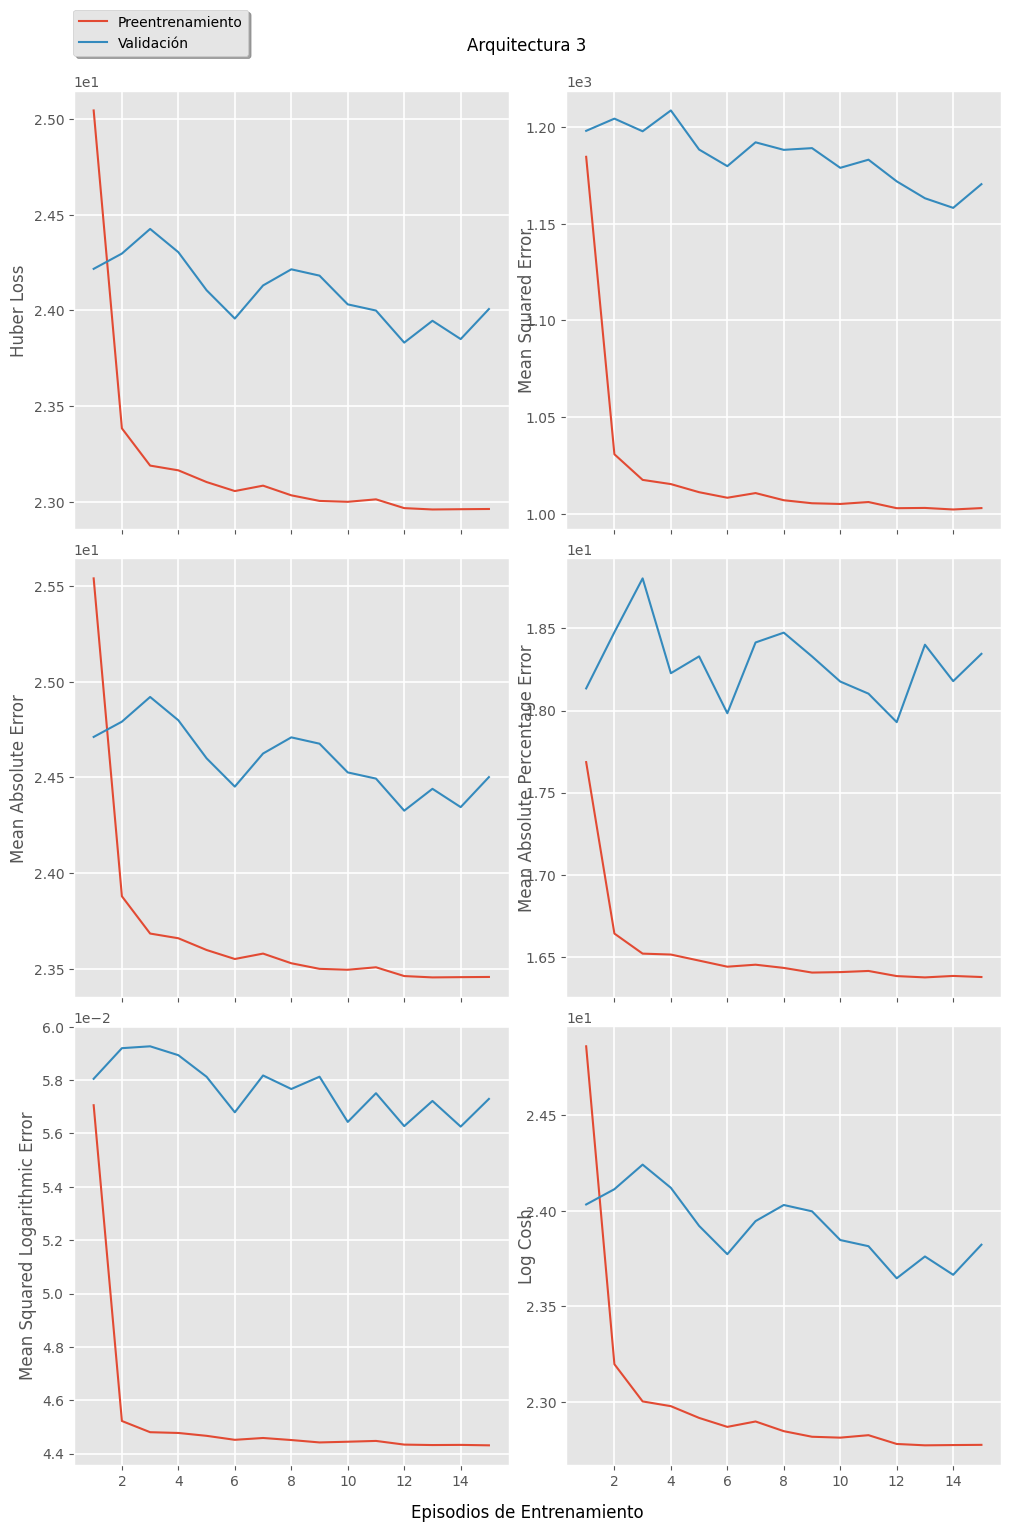

"\nfor key_index,key in list(history.history.keys())[1:7]:\n  fig, ax = plt.subplots()                               #simple matplotlib visualization of the performance in training loss of the model over the training epochs\n  ax.plot(np.arange(1,EPOCHS+1),history.history[key],label=key)\n  ax.plot(np.arange(1,EPOCHS+1),history.history['val_'+key],label='val_'+key)\n  ax.xaxis.set_major_locator(MaxNLocator(integer=True))\n  plt.xlabel('Epochs')\n  plt.ylabel('Loss')\n  plt.legend()\n  plt.grid()\n  plt.show()\n  print('------------------------')\n"

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

keys=list(history.history.keys())[1:7]

plt.style.use("ggplot")
fig, axs = plt.subplots(3, 2, sharex=True, sharey=False, figsize=(10, 15))
fig.suptitle(t='Arquitectura '+str(ARCHITECTURE_NUMBER),y=1)
fig.supxlabel('Episodios de Entrenamiento')
fig.tight_layout()

for key_index,key in enumerate(keys):
  column=key_index%2
  row=int(key_index/2)

  axs[row,column].plot(np.arange(1,EPOCHS+1),history.history[key],label='Preentrenamiento')
  axs[row,column].plot(np.arange(1,EPOCHS+1),history.history['val_'+key],label='Validación')
  axs[row,column].grid(which='major', color='white', linewidth=1.2)
  axs[row,column].set_ylabel(key.replace("_", " " ).title())
  axs[row,column].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

  if column==1:
    axs[row,column].yaxis.set_label_coords(-0.07,0.5)

  if row==0 and column==0:
    axs[row,column].legend(loc='upper center', bbox_to_anchor=(0.2, 1.20), fancybox=True, shadow=True)

plt.show()

'''
for key_index,key in list(history.history.keys())[1:7]:
  fig, ax = plt.subplots()                               #simple matplotlib visualization of the performance in training loss of the model over the training epochs
  ax.plot(np.arange(1,EPOCHS+1),history.history[key],label=key)
  ax.plot(np.arange(1,EPOCHS+1),history.history['val_'+key],label='val_'+key)
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()
  plt.show()
  print('------------------------')
'''

In [ ]:
test_history=model.evaluate_generator(test_generator,steps=int(test_generator.__len__()))

In [ ]:
print(test_history)

[802.8757934570312, 20.318044662475586, 802.8757934570312, 20.812049865722656, 16.546632766723633, 0.0448019914329052, 20.133649826049805]


And yet, in this situation, we can visualize the predictions of the model over the patients in the control group, patients that our model have not yet seen. We can check visually with a simple matplotlib graph wether this predictions have some coherence comparing with the ground truth of the data over some patients in the control group.

In [ ]:
pretrained_model = keras.models.load_model(checkpoint_folder + 'pretrained_glucose_predictor(ARCHITECTURE_'+str(ARCHITECTURE_NUMBER)+').h5',compile=False)

loss=losses[best_classifier['loss']]                           #define that last combination of relatively optimized hyperparameters into parameters that can define our next models
optimizer=optimizers[best_classifier['optimizer']]
learning_rate=float(best_classifier['learning_rate'])

pretrained_model.compile(loss=loss,optimizer=optimizer,metrics=metrics)  #compile the model with the optimized parameters of optimizer and loss that we searched earlier
K.set_value(pretrained_model.optimizer.learning_rate, learning_rate)     #compile the model with the optimized parameter of learning rate that we searched earlier

In [ ]:
test_generator=Custom_Generator([test_patients[0]],1)     #create a fit generator over patients in the control group with batch size equal to 1

In [ ]:
import matplotlib.pyplot as plt

X_test=np.array([np.squeeze(test_generator.__getitem__(i)[0]) for i in range(0,int(test_generator.__len__()-1))])   #we first extract the X data and the ground truth from the test generator
Y_test=np.array([np.squeeze(test_generator.__getitem__(i)[1]) for i in range(0,int(test_generator.__len__()-1))])
#X_test=denormalize(X_test)
#Y_test=denormalize(Y_test)

print(np.shape(X_test))   #Check those shapes to observe if it have coherence over the sahpe that it have to have (number of windows,WINDOW_LENGTH,1)
print(np.shape(Y_test))   #(number of windows,1)

(109175, 6)
(109175,)


3/3 [==============================] - 1s 14ms/step


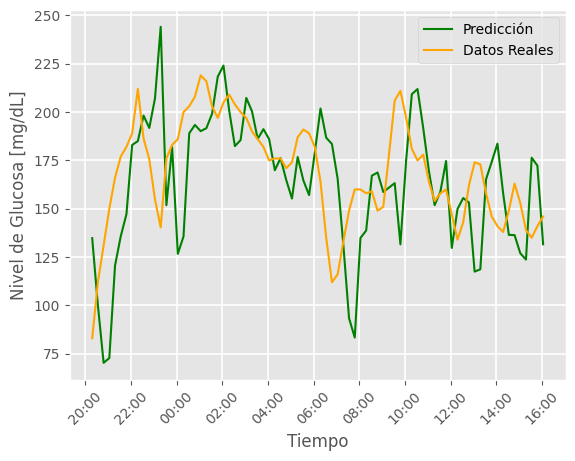

In [ ]:
predictions=model.predict(X_test[:80])      #We check the first 150 elements predictions from the test generator and compare to its correspondent ground truth elements

fig, ax = plt.subplots()
ax.plot(timestamps_test[:80],predictions,label='Predicción',color='green')
ax.plot(timestamps_test[:80],Y_test[:80],label='Datos Reales',color='orange')

#ax.xaxis.set_major_locator(md.MinuteLocator(byminute = [0, 20]))
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45)

plt.ylabel('Nivel de Glucosa [mg/dL]')
plt.xlabel('Tiempo')
plt.legend()
plt.grid(which='major', color='white', linewidth=1.2)
plt.show()

3/3 [==============================] - 0s 4ms/step


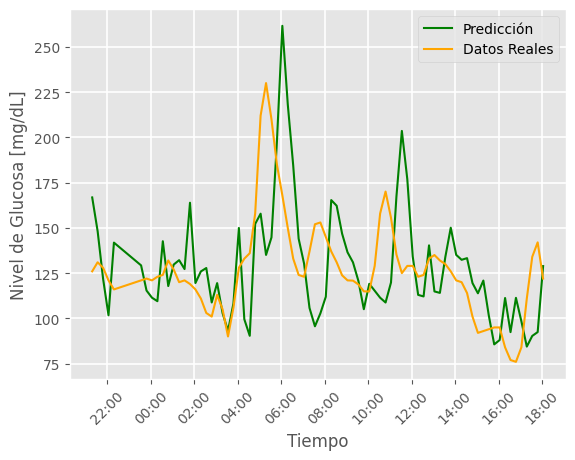

In [ ]:
predictions=model.predict(X_test[100:180])      #We check the first 150 elements predictions from the test generator and compare to its correspondent ground truth elements

fig, ax = plt.subplots()

ax.plot(timestamps_test[100:180],predictions,label='Predicción',color='green')
ax.plot(timestamps_test[100:180],Y_test[100:180],label='Datos Reales',color='orange')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45)

plt.ylabel('Nivel de Glucosa [mg/dL]')
plt.xlabel('Tiempo')
plt.legend()
plt.grid(which='major', color='white', linewidth=1.2)
plt.show()

3/3 [==============================] - 0s 4ms/step


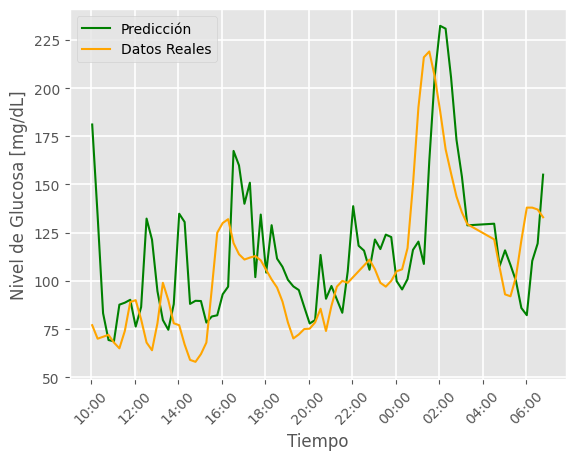

In [ ]:
predictions=model.predict(X_test[300:380])      #We check the first 150 elements predictions from the test generator and compare to its correspondent ground truth elements

fig, ax = plt.subplots()

ax.plot(timestamps_test[300:380],predictions,label='Predicción',color='green')
ax.plot(timestamps_test[300:380],Y_test[300:380],label='Datos Reales',color='orange')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45)

plt.ylabel('Nivel de Glucosa [mg/dL]')
plt.xlabel('Tiempo')
plt.legend()
plt.grid(which='major', color='white', linewidth=1.2)
plt.show()

##Pretrained Model vs From the Scratch Model

Now, we are going to try to train individually in each patient from the control group. We are going o try to do that without fit generator, fit generator was aahelpful tool to train the neural network trough all the patients with a single call and without having to worry about GPU memory, now, we are going to try to work with this data without fit generator, which is more helpful for individually training.

0-LIB193277

PRETRAINED_MODEL
Epoch 1/15
2457/2457 [==============================] - 25s 9ms/step - loss: 568.5176 - huber_loss: 17.5077 - mean_squared_error: 568.4907 - mean_absolute_error: 18.0012 - mean_absolute_percentage_error: 15.9930 - mean_squared_logarithmic_error: 0.0403 - log_cosh: 17.3240 - val_loss: 470.6873 - val_huber_loss: 15.7429 - val_mean_squared_error: 470.6475 - val_mean_absolute_error: 16.2350 - val_mean_absolute_percentage_error: 14.9396 - val_mean_squared_logarithmic_error: 0.0358 - val_log_cosh: 15.5608
Epoch 2/15
2457/2457 [==============================] - 20s 8ms/step - loss: 564.6582 - huber_loss: 17.4567 - mean_squared_error: 564.6267 - mean_absolute_error: 17.9503 - mean_absolute_percentage_error: 15.9371 - mean_squared_logarithmic_error: 0.0400 - log_cosh: 17.2730 - val_loss: 471.4546 - val_huber_loss: 15.8023 - val_mean_squared_error: 471.4126 - val_mean_absolute_error: 16.2947 - val_mean_absolute_percentage_error: 15.0793 - val_mean_squared_logarithmi

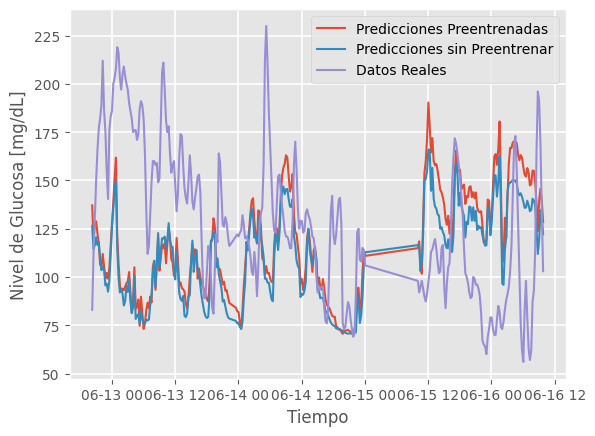


-------------------------------------------------------

1-LIB193307

PRETRAINED_MODEL
Epoch 1/15
2264/2264 [==============================] - 27s 9ms/step - loss: 894.7652 - huber_loss: 22.0461 - mean_squared_error: 894.6781 - mean_absolute_error: 22.5409 - mean_absolute_percentage_error: 16.5531 - mean_squared_logarithmic_error: 0.0436 - log_cosh: 21.8604 - val_loss: 829.4141 - val_huber_loss: 21.4234 - val_mean_squared_error: 829.1349 - val_mean_absolute_error: 21.9181 - val_mean_absolute_percentage_error: 15.9581 - val_mean_squared_logarithmic_error: 0.0396 - val_log_cosh: 21.2378
Epoch 2/15
2264/2264 [==============================] - 18s 8ms/step - loss: 893.9393 - huber_loss: 22.0208 - mean_squared_error: 893.8483 - mean_absolute_error: 22.5157 - mean_absolute_percentage_error: 16.5168 - mean_squared_logarithmic_error: 0.0435 - log_cosh: 21.8352 - val_loss: 829.1345 - val_huber_loss: 21.4605 - val_mean_squared_error: 829.6484 - val_mean_absolute_error: 21.9549 - val_mean_absolu

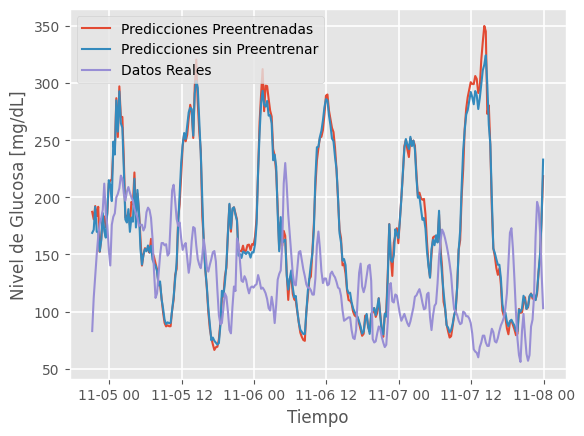


-------------------------------------------------------

2-LIB193385

PRETRAINED_MODEL
Epoch 1/15
2043/2043 [==============================] - 24s 9ms/step - loss: 490.3834 - huber_loss: 15.8499 - mean_squared_error: 490.3495 - mean_absolute_error: 16.3425 - mean_absolute_percentage_error: 13.8872 - mean_squared_logarithmic_error: 0.0320 - log_cosh: 15.6677 - val_loss: 460.4556 - val_huber_loss: 16.2282 - val_mean_squared_error: 460.4736 - val_mean_absolute_error: 16.7218 - val_mean_absolute_percentage_error: 14.5849 - val_mean_squared_logarithmic_error: 0.0314 - val_log_cosh: 16.0444
Epoch 2/15
2043/2043 [==============================] - 18s 9ms/step - loss: 486.6949 - huber_loss: 15.7782 - mean_squared_error: 486.6620 - mean_absolute_error: 16.2709 - mean_absolute_percentage_error: 13.8318 - mean_squared_logarithmic_error: 0.0318 - log_cosh: 15.5960 - val_loss: 456.6584 - val_huber_loss: 16.1506 - val_mean_squared_error: 456.6772 - val_mean_absolute_error: 16.6442 - val_mean_absolu

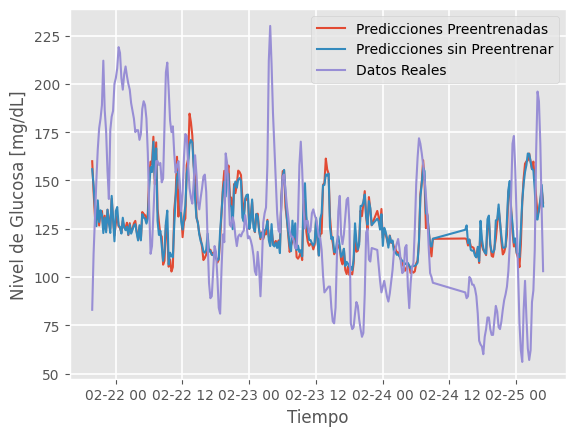


-------------------------------------------------------

3-LIB193367

PRETRAINED_MODEL
Epoch 1/15
1626/1626 [==============================] - 20s 10ms/step - loss: 1016.7763 - huber_loss: 23.5613 - mean_squared_error: 1017.0611 - mean_absolute_error: 24.0565 - mean_absolute_percentage_error: 16.9846 - mean_squared_logarithmic_error: 0.0459 - log_cosh: 23.3753 - val_loss: 1030.1176 - val_huber_loss: 23.1613 - val_mean_squared_error: 1029.0785 - val_mean_absolute_error: 23.6567 - val_mean_absolute_percentage_error: 15.8547 - val_mean_squared_logarithmic_error: 0.0468 - val_log_cosh: 22.9755
Epoch 2/15
1626/1626 [==============================] - 14s 8ms/step - loss: 1012.7300 - huber_loss: 23.5130 - mean_squared_error: 1013.0932 - mean_absolute_error: 24.0084 - mean_absolute_percentage_error: 16.9391 - mean_squared_logarithmic_error: 0.0457 - log_cosh: 23.3269 - val_loss: 992.4656 - val_huber_loss: 22.5104 - val_mean_squared_error: 991.2577 - val_mean_absolute_error: 23.0045 - val_mean

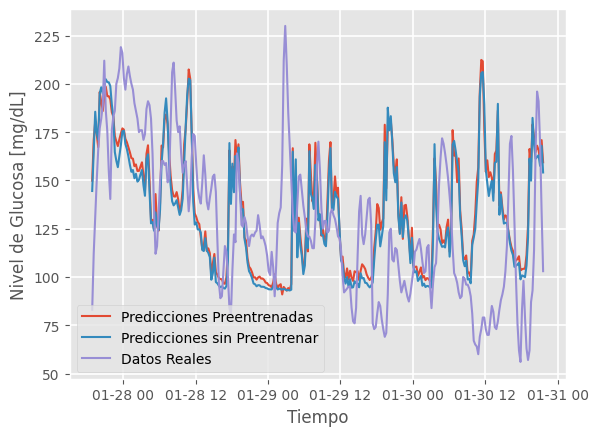


-------------------------------------------------------

4-LIB193310

PRETRAINED_MODEL
Epoch 1/15
1580/1580 [==============================] - 19s 9ms/step - loss: 935.1452 - huber_loss: 22.3064 - mean_squared_error: 935.1359 - mean_absolute_error: 22.8014 - mean_absolute_percentage_error: 16.9606 - mean_squared_logarithmic_error: 0.0466 - log_cosh: 22.1207 - val_loss: 824.0255 - val_huber_loss: 22.7011 - val_mean_squared_error: 823.5695 - val_mean_absolute_error: 23.1981 - val_mean_absolute_percentage_error: 19.7033 - val_mean_squared_logarithmic_error: 0.0499 - val_log_cosh: 22.5132
Epoch 2/15
1580/1580 [==============================] - 14s 9ms/step - loss: 931.0151 - huber_loss: 22.2584 - mean_squared_error: 931.0172 - mean_absolute_error: 22.7529 - mean_absolute_percentage_error: 16.9272 - mean_squared_logarithmic_error: 0.0464 - log_cosh: 22.0731 - val_loss: 790.9747 - val_huber_loss: 21.8926 - val_mean_squared_error: 790.3582 - val_mean_absolute_error: 22.3888 - val_mean_absolu

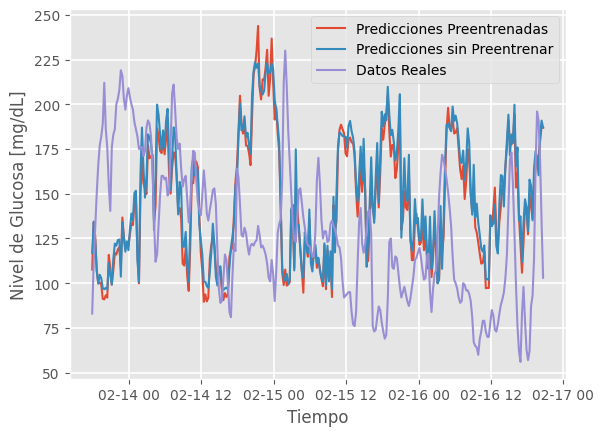


-------------------------------------------------------



In [ ]:
training_startime=time.time()
pretrained_metrics=[]                                                                             #Lists where we are going to store the control group patients metrics for the pretrained and the 'from the scratch' model
fromthescratch_metrics=[]
test_pretrained_metrics=[]                                                                             #Lists where we are going to store the control group patients metrics for the pretrained and the 'from the scratch' model
test_fromthescratch_metrics=[]

for ind,patient in enumerate(test_patients):                                                                      #A loop trough every filenames patient
  print(str(ind)+'-'+(patient)+'\n')

  pretrained_model = keras.models.load_model(checkpoint_folder + 'pretrained_glucose_predictor(ARCHITECTURE_'+str(ARCHITECTURE_NUMBER)+').h5',compile=False)#custom_objects={"Huber": tf.keras.losses.Huber() })    #Load the pretrained model and create a 'from the scratch' model
  fromthescratch_model=create_model()
  loss=losses[best_classifier['loss']]                           #define that last combination of relatively optimized hyperparameters into parameters that can define our next models
  optimizer=optimizers[best_classifier['optimizer']]
  learning_rate=float(best_classifier['learning_rate'])
  fromthescratch_model.compile(loss=loss,optimizer=optimizer,metrics=metrics)  #compile the model with the optimized parameters of optimizer and loss that we searched earlier
  K.set_value(fromthescratch_model.optimizer.learning_rate, learning_rate)     #compile the model with the optimized parameter of learning rate that we searched earlier
  pretrained_model.compile(loss=loss,optimizer=optimizer,metrics=metrics)  #compile the model with the optimized parameters of optimizer and loss that we searched earlier
  K.set_value(pretrained_model.optimizer.learning_rate, learning_rate)     #compile the model with the optimized parameter of learning rate that we searched earlier

  windowed_data=np.load(os.path.join(src_folder,patient)+'.npy',allow_pickle=True)                          #Load its correspondent windowed dataset
  X=np.array([window[:WINDOW_STEPS,:] for window in windowed_data])
  Y=np.array([window[-1,:] for window in windowed_data])

  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False, random_state=42)

  print('PRETRAINED_MODEL')
  pretrained_history=pretrained_model.fit(x=X_train,y=y_train,shuffle=False,epochs=TOTAL_EPOCHS,batch_size=32,validation_split=0.1,verbose=1)
  print('\nFROMTHESCRATCH_MODEL')
  fromthescratch_history=fromthescratch_model.fit(x=X_train,y=y_train,shuffle=False,epochs=TOTAL_EPOCHS,batch_size=32,validation_split=0.1,verbose=1)

  test_pretrained_history=pretrained_model.evaluate(x=X_test,y=y_test,batch_size=32)
  test_fromthescratch_history=fromthescratch_model.evaluate(x=X_test,y=y_test,batch_size=32)

  pretrained_metrics.append(pretrained_history)
  fromthescratch_metrics.append(fromthescratch_history)
  test_pretrained_metrics.append(test_pretrained_history)
  test_fromthescratch_metrics.append(test_fromthescratch_history)

  Y_pretrained_prediction=pretrained_model.predict(X_test)
  Y_fromthescratch_prediction=fromthescratch_model.predict(X_test)
  plt.plot(partial_timestamps[ind][:300],Y_pretrained_prediction[:300],label='Predicciones Preentrenadas')
  plt.plot(partial_timestamps[ind][:300],Y_fromthescratch_prediction[:300],label='Predicciones sin Preentrenar')
  plt.plot(partial_timestamps[ind][:300],Y_test[:300],label='Datos Reales')
  plt.legend()
  plt.ylabel('Nivel de Glucosa [mg/dL]')
  plt.xlabel('Tiempo')
  plt.grid(which='major', color='white', linewidth=1.2)
  plt.show()

  print('\n-------------------------------------------------------\n')

training_endtime=time.time()
training_time=(training_endtime-training_startime)

In [ ]:
for ind in range(0,len(test_patients)):
  np.save(checkpoint_folder+'pretrained_metrics_'+str(ind)+'(ARCHITECTURE_'+str(ARCHITECTURE_NUMBER)+').npy',pretrained_metrics[ind].history)
  np.save(checkpoint_folder+'fromthescratch_metrics_'+str(ind)+'(ARCHITECTURE_'+str(ARCHITECTURE_NUMBER)+').npy',fromthescratch_metrics[ind].history)
  np.save(checkpoint_folder+'test_pretrained_metrics_'+str(ind)+'(ARCHITECTURE_'+str(ARCHITECTURE_NUMBER)+').npy',np.array(test_pretrained_metrics[ind]))
  np.save(checkpoint_folder+'test_fromthescratch_metrics_'+str(ind)+'(ARCHITECTURE_'+str(ARCHITECTURE_NUMBER)+').npy',np.array(test_fromthescratch_metrics[ind]))

In [ ]:
notebook_endtime=time.time()
notebook_time=(notebook_endtime-notebook_startime)

print(notebook_time)
print(optimization_time)
print(pretraining_time)
print(training_time)

6701.302097797394
1731.1921968460083
2009.985488653183
2700.896502017975


In [ ]:
print('Notebook Execution Time: '+str(round(notebook_time/3600,2))+' hours')
print('Hyperparameter Optimization Execution Time: '+str(round(optimization_time/3600,2))+' hours')
print('Pretraining Execution Time: '+str(round(pretraining_time/3600,2))+' hours')
print('Training Execution Time: '+str(round(training_time/3600,2))+' hours')

Notebook Execution Time: 1.86 hours
Hyperparameter Optimization Execution Time: 0.48 hours
Pretraining Execution Time: 0.56 hours
Training Execution Time: 0.75 hours
